<a href="https://colab.research.google.com/github/johanlopezs/YOLO_microorganism/blob/modificacion_yolo/Tutorial_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/johanlopezs/YOLO_microorganism.git
%cd /content/YOLO_microorganism
%pip install -qr requirements.txt
!pip install zenodo_get
!pip install rarfile
import torch
import os
import zenodo_get
import rarfile


Cloning into 'YOLO_microorganism'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 190 (delta 50), reused 77 (delta 35), pack-reused 65
Receiving objects: 100% (190/190), 1.47 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/YOLO_microorganism
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.
Looking in indexes: https://pypi.org/si

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil
import os

# Ruta de la carpeta que deseas copiar
ruta_origen = '/content/drive/MyDrive/optical_microscopy_images'

# Ruta de la carpeta destino
ruta_destino = '/content/YOLO_microorganism/optical_microscopy_images'

# Copiar la carpeta de origen a la carpeta destino
shutil.copytree(ruta_origen, ruta_destino)

'/content/YOLO_microorganism/optical_microscopy_images'

Tutorial entrenar y preparar los datos.
Los datos pueden ser descargardos usando el siguiente link: https://zenodo.org/record/7643929
se requiere ademas el uso de las bibliotecas 


*   zenodo_get
*   rarfile



In [ ]:

# # nos ubicamos en el lugar en donde se descargaran los datos.
%cd /content/YOLO_microorganism
# # usando la funcion zenodo_get descargamos la base de datos.
!zenodo_get https://zenodo.org/record/7657731

# descomprimimos el archivo .rar
# Creamos un objeto de tipo RarFile con la ruta al archivo .rar que queremos descomprimir
archivo_rar = rarfile.RarFile("Cryptosporidium.rar")
# # Extraemos el contenido del archivo .rar a una carpeta
archivo_rar.extractall("/content/YOLO_microorganism")

# Elegir el set de datos.

In [4]:
# verificamos la informacion en cada uno de los set de datos en los archivos .yaml
dataset = 'optical_microscopy_images' #@param ['optical_microscopy_images', 'phase_contrast_microscopy_images']
%cd /content/YOLO_microorganism
if dataset == 'optical_microscopy_images':
  print ('----------------optical_microscopy_images-----------------------------')
  !cat optical_microscopy_images/data.yaml
else: 
  print ('\n-----------------phase_contrast_microscopy_images----------------------------')
  !cat phase_contrast_microscopy_images/data.yaml

/content/YOLO_microorganism
----------------optical_microscopy_images-----------------------------
names:
- Giardia
- C. parvum
nc: 2
train: optical_microscopy_images/train/images
val: optical_microscopy_images/valid/images


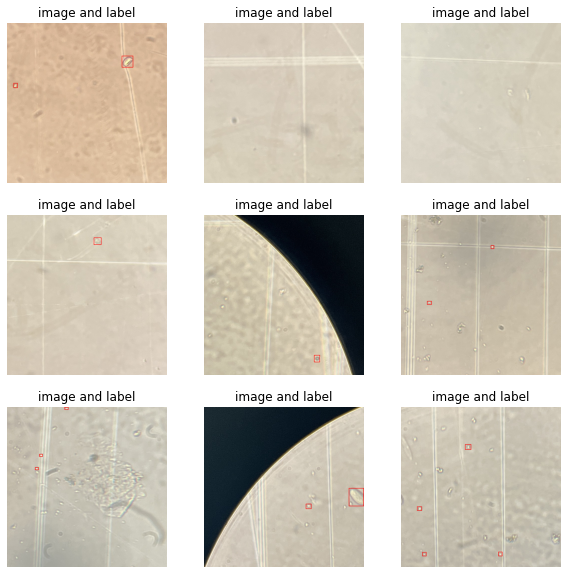

In [5]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def yolo_to_xml_bbox(bbox, w, h):
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        draw.rectangle(bbox, outline="red", width=2)
    plt.imshow(img)
    plt.title('image and label')
    plt.axis('off')
    plt.show

images_dir = dataset + '/valid/images/'
images = !ls -1 '{images_dir}'
labels_dir = dataset +'/valid/labels/'
labels = !ls -1 '{labels_dir}'

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  bboxes = []
  img = Image.open(images_dir + images[i])
  if os.path.getsize(labels_dir + labels[i]) > 5:
    with open(labels_dir + labels[i], 'r', encoding='utf8') as f:
        for line in f:
            data = line.strip().split(' ')
            bbox = [float(x) for x in data[1:]]
            bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))
  draw_image(img, bboxes)


# seleccionar entre los 3 modelos: [YOLOs, YOLOm y YOLOl]

In [ ]:
%cd /content/YOLO_microorganism
modelo = 'YOLOs' #@param['YOLOs', 'YOLOm','YOLOl']
datos = 'optical_microscopy_images'
if modelo == 'YOLOs':
  !python train.py --img 640 --batch 16 --epochs 10 --data {dataset}/data.yaml --weights yolov5s.pt --cache  
elif modelo == 'YOLOm':
  !python train.py --img 640 --batch 16 --epochs 10 --data {dataset}/data.yaml --weights yolov5m.pt --cache
elif modelo == 'YOLOl':
  !python train.py --img 640 --batch 16 --epochs 10 --data {dataset}/data.yaml --weights yolov5l.pt --cache


# realizar prediciones

In [8]:
exp = 'runs/train'
names = !ls -1 '{exp}'
print('Lista de exprimentos')
for i in names:
  print(exp + '/' + i)

Lista de exprimentos
runs/train/exp


Aqui se debe de poner la ruta con el exprimento con el cual se planea hacer la prediccion. 

In [ ]:
Experiment = 'runs/train/exp' #@param {type:"string"}
subfolder_name = Experiment + '/weights/last.pt'
route_weights = os.path.join(subfolder_name)
source_ = dataset + '/test/images'
source_ = os.path.join(source_)
%cd /content/YOLO_microorganism
!python detect.py --weights $route_weights --img 640 --conf 0.1 --source $source_


In [12]:
predict = 'runs/detect'
names = !ls -1 '{predict}'
for i in names:
  print(predict + '/' + i)

runs/detect/exp
runs/detect/exp2


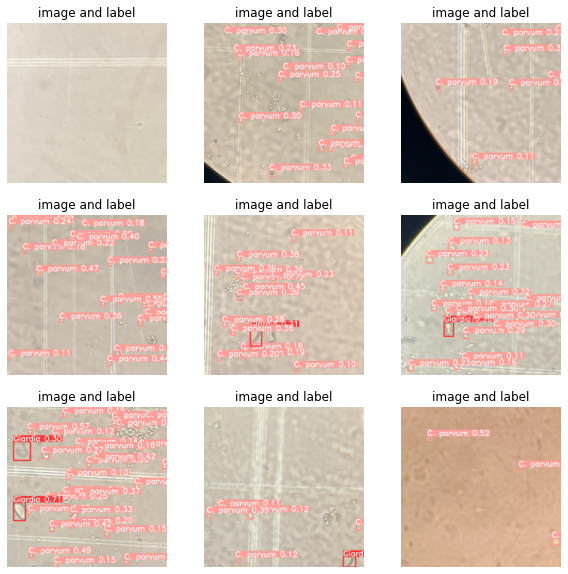

In [17]:
img_route = 'runs/detect/exp2' #@param {type:'string'}
images_ = !ls -1 '{img_route}'

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  img = Image.open(img_route + '/' + images_[i])
  plt.imshow(img)
  plt.title('image and label')
  plt.axis('off')
  plt.show
